In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import seaborn as sns

In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

### Load Data

In [172]:
kc_dt_url = "https://raw.githubusercontent.com/junjiewu-mtl/glis630_final_project/master/kc_house_data.csv"

In [173]:
url = kc_dt_url
hp_data = pd.read_csv(url)
#hp_data.count()

In [174]:
hp_data.duplicated().describe()

count     21613
unique        1
top       False
freq      21613
dtype: object

In [210]:
#converted week of year as a factor features
hp_data["date"] = hp_data["date"].str[0:8]
hp_data["formatted_date"] = pd.to_datetime(hp_data["date"])
#save seperate feature data for data viz
feature_dt = hp_data.drop(['price'], axis = 1)
feature_dt['index'] = np.arange(len(feature_dt))

### Data Prep

In [211]:
#drop unuse features
df1 = hp_data.drop(["id", "date", "lat", "long","formatted_date"], axis=1)

In [212]:
#covert features from numerical to factor
df1[['waterfront','zipcode','yr_built','yr_renovated']] = df1[['waterfront','zipcode','yr_built','yr_renovated']].astype('category')

In [213]:
df1 = pd.get_dummies(df1)
# Display the first 5 rows of the last 12 columns
df1.head(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,0,3,6,770,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1050,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,...,0,0,0,0,0,0,0,0,0,0


In [214]:
df1[['price']].describe().round(0)

,price
count,21613.0
mean,540088.0
std,367127.0
min,75000.0
25%,321950.0
50%,450000.0
75%,645000.0
max,7700000.0


In [215]:
cut_labels_2 = ['lower_price', 'higher_price']
cut_bins = [0, 645000, 7700000]
df1['cut_ex1'] = pd.cut(df1['price'], bins=cut_bins, labels=cut_labels_2)
df1['cut_ex1'].value_counts()

lower_price     16240
higher_price     5373
Name: cut_ex1, dtype: int64

In [216]:
#save lower and higher price dataframe
df1_lower = df1[df1['cut_ex1'] == "lower_price"]
df1_higher = df1[df1['cut_ex1'] == "higher_price"]

#drop the price label
df1_lower = df1_lower.drop(["cut_ex1"], axis=1)
df1_higher = df1_higher.drop(["cut_ex1"], axis=1)

In [231]:
df1_lower.to_csv('~/Desktop/kc_lower.csv') 
df1_higher.to_csv('~/Desktop/kc_higher.csv') 



## Regression Tree Model

In [74]:
rt_train_dt = df1.sample(frac=0.8, random_state=0)
rt_test_dt = df1.drop(rt_train_dt.index)

In [37]:
# regression tree method
rt_train_x = rt_train_dt.drop(["price"], axis=1)
rt_train_y = rt_train_dt[["price"]]

In [38]:
rt = tree.DecisionTreeRegressor()
rt.fit(rt_train_x, rt_train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [39]:
#predicted price from the regression tree
rt_predict_price = pd.DataFrame(rt.predict(rt_test_dt.drop(["price"], axis=1)), columns=["p_price"])

In [40]:
#add row number to predicted price for merging
rt_predict_price['index'] = np.arange(len(rt_predict_price))

In [41]:
#add row number to true price for merging
rt_test_price = rt_test_dt[['price']]
rt_test_price['index'] = np.arange(len(rt_test_price))

/Users/junjiewu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
#merge predicted and test price in to a df
rt_price = rt_predict_price.merge(rt_test_price, left_on='index', right_on='index').round(0)

In [24]:
# Calculate the absolute errors
rt_errors = abs(rt_price['p_price'] - rt_price['price'])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(rt_errors), 2), 'USD.')

Mean Absolute Error: 112253.62 USD.


In [25]:
# Calculate mean absolute percentage error (MAPE)
rt_mape = 100 * (rt_errors / rt_price['price'])
# Calculate and display accuracy
rt_accuracy = 100 - np.mean(rt_mape)
print('Accuracy:', round(rt_accuracy, 2), '%.')

#Accuracy: 78.74 %.

Accuracy: 78.8 %.


In [27]:
#MSE
from sklearn.metrics import mean_squared_error

mean_squared_error(rt_price['price'], rt_price['p_price'])

#39037669760.21212

39923938685.444595

## Random Forest

In [218]:
#fit the model with lower or higher pirce house data
rf_df = df1_higher

In [219]:
# Labels are the values we want to predict
rf_labels = np.array(rf_df['price'])
# Remove the labels from the features
# axis 1 refers to the columns
rf_features= rf_df.drop('price', axis = 1)
# Saving feature names for later use
rf_feature_list = list(rf_features.columns)
# Convert to numpy array
rf_features = np.array(rf_features)
#normalize features
rf_features = rf_features / np.linalg.norm(rf_features)

In [220]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
rf_train_features, rf_test_features, rf_train_labels, rf_test_labels = train_test_split(rf_features, rf_labels, test_size = 0.1, random_state = 42)

In [221]:
print('Training Features Shape:', rf_train_features.shape)
print('Training Labels Shape:', rf_train_labels.shape)
print('Testing Features Shape:', rf_test_features.shape)
print('Testing Labels Shape:', rf_test_labels.shape)

Training Features Shape: (4835, 270)
Training Labels Shape: (4835,)
Testing Features Shape: (538, 270)
Testing Labels Shape: (538,)


In [222]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

import timeit
start = timeit.default_timer()

# Train the model on training data
rf.fit(rf_train_features, rf_train_labels);

stop = timeit.default_timer()
print('Time: ', stop - start)  

#n=1000 runtime 560s

Time:  127.57744417300273


In [223]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(rf_test_features)
# Calculate the absolute errors
rf_errors = abs(rf_predictions - rf_test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(rf_errors), 2), 'USD')

#set grade, view, condition, as numerical variable, 
#year as factor
#n=100, 87758.11

#year as numeric
#n=100, 87997.43 

#normalized features
#year as factor
#n=1000,  85901.03 USD

Mean Absolute Error: 137265.62 USD


In [224]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# Calculate the root mean square error
rf_rms = sqrt(mean_squared_error(rf_test_labels, rf_predictions))

print('RMSE:', round(np.mean(rf_rms), 2))

RMSE: 243635.59


In [225]:
import plotly
from plotly import version
print (version)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

<module 'plotly.version' from '/Users/junjiewu/opt/anaconda3/lib/python3.7/site-packages/plotly/version.py'>


In [227]:
# x and y given as DataFrame columns
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=rf_test_labels, y=rf_predictions, mode='markers'))

fig.add_trace(go.Scatter(x=[0,7000000], y = [0,7000000],
                    mode='lines',
                    name='True Value'))
fig.show()

In [197]:
# Calculate mean absolute percentage error (MAPE)
rf_mape = 100 * (rf_errors / rf_test_labels)
# Calculate and display accuracy
rf_accuracy = 100 - np.mean(rf_mape)
print('Accuracy:', round(rf_accuracy, 2), '%.')

#year as factors
#n=100, 83.57%
#n=500, 83.72%
#n=1000, 83.74%

#year as numerical
#n=100, 83.57%
#n=1000, 83.49%

#normalized features
#n=500, 84.04
#n=1000, 84.06%

#Accuracy: 84.71 %.


Accuracy: 85.35 %.


In [545]:
# Necessary imports: 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [546]:
# Perform 5-fold cross validation
cv_predictions = cross_val_predict(rf, rf_features, rf_labels, cv=5)


In [553]:
accuracy = metrics.r2_score(rf_labels, cv_predictions)
accuracy

0.8331371361378984

In [554]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=rf_labels, y=cv_predictions, mode='markers'))

fig.add_trace(go.Scatter(x=[0,7000000], y = [0,7000000],
                    mode='lines',
                    name='True Value'))
fig.show()

### Variable Importances

In [228]:
# Get numerical feature importances
rf_importances = list(rf.feature_importances_)
# List of tuples with variable and importance
rf_feature_importances = [(rf_feature, round(rf_importance, 4)) for rf_feature, rf_importance in zip(rf_feature_list, rf_importances)]
# Sort the feature importances by most important first
rf_feature_importances = sorted(rf_feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in rf_feature_importances];


Variable: sqft_living          Importance: 0.4655
Variable: zipcode_98004        Importance: 0.0476
Variable: grade                Importance: 0.0424
Variable: sqft_living15        Importance: 0.0387
Variable: waterfront_0         Importance: 0.0379
Variable: view                 Importance: 0.0369
Variable: waterfront_1         Importance: 0.0357
Variable: zipcode_98039        Importance: 0.0337
Variable: sqft_above           Importance: 0.0309
Variable: zipcode_98112        Importance: 0.0309
Variable: sqft_lot15           Importance: 0.0292
Variable: sqft_lot             Importance: 0.0285
Variable: sqft_basement        Importance: 0.0159
Variable: zipcode_98040        Importance: 0.011
Variable: condition            Importance: 0.0092
Variable: zipcode_98105        Importance: 0.0073
Variable: zipcode_98119        Importance: 0.0062
Variable: bedrooms             Importance: 0.0059
Variable: zipcode_98033        Importance: 0.0056
Variable: yr_renovated_0       Importance: 0.0037
V

In [199]:
x_values = list(range(len(rf_importances)))
# List of features sorted from most to least important
rf_sorted_importances = [rf_importance[1] for rf_importance in rf_feature_importances]
rf_sorted_features = [rf_importance[0] for rf_importance in rf_feature_importances]
# Cumulative importances
rf_cumulative_importances = np.cumsum(rf_sorted_importances)
# Make a line graph
# plt.plot(x_values, rf_cumulative_importances, 'g-')
# # Draw line at 95% of importance retained
# plt.hlines(y = 0.95, xmin=0, xmax=len(rf_sorted_importances), color = 'r', linestyles = 'dashed')
# # Format x ticks and labels
# plt.xticks(x_values, rf_sorted_features, rotation = 'vertical')
# # Axis labels and title
# plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');plt.rcParams['figure.figsize'] = [500, 50]

In [200]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(rf_cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 91


In [78]:
# Extract the names of the most important features
rf_important_feature_names = [rf_feature[0] for rf_feature in rf_feature_importances[0:46]]
# Find the columns of the most important features
rf_important_indices = [rf_feature_list.index(rf_feature) for rf_feature in rf_important_feature_names]
# Create training and testing sets with only the important features
rf_important_train_features = rf_train_features[:, rf_important_indices]
rf_important_test_features = rf_test_features[:, rf_important_indices]
# Sanity check on operations
print('Important train features shape:', rf_important_train_features.shape)
print('Important test features shape:', rf_important_test_features.shape)

Important train features shape: (19134, 46)
Important test features shape: (2126, 46)


In [80]:
#counting the runtime
start = timeit.default_timer()  

# Train the expanded model on only the important features
rf.fit(rf_important_train_features, rf_train_labels);

stop = timeit.default_timer()
print('Time: ', stop - start)

# Make predictions on test data
rf_import_predictions = rf.predict(rf_important_test_features)
# Performance metrics
rf_import_errors = abs(rf_import_predictions - rf_test_labels)
print('Average absolute error:', round(np.mean(rf_import_errors), 2), 'USD.')
# Calculate mean absolute percentage error (MAPE)
rf_import_mape = 100 * (rf_import_errors / rf_test_labels)
# Calculate and display accuracy
rf_import_accuracy = 100 - np.mean(rf_import_mape)
print('Accuracy:', round(rf_import_accuracy, 2), '%.')

from math import sqrt

# Calculate the root mean square error
rf_import_rms = sqrt(mean_squared_error(rf_test_labels, rf_import_predictions))
print('RMSE:', round(np.mean(rf_import_rms), 2), 'USD')


# Time:  207.77607357499073
# Average absolute error: 91.31 thousands USD
# Accuracy: 82.59 %


Time:  190.48574922999978
Average absolute error: 93473.31 USD.
Accuracy: 82.08 %.
RMSE: 172112.63 USD


In [84]:
# Calculate the root mean square error
rf_import_rms = sqrt(mean_squared_error(rf_test_labels, rf_import_predictions))

print('RMSE:', round(np.mean(rf_import_rms), 2))

RMSE: 172112.63


In [ ]:
plt.scatter(rf_test_labels, predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [pirce]')
plt.rcParams['figure.figsize'] = [15, 8]
lims = [0, 5000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


## 3 Layers Neural Network

In [766]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [829]:
#drop unuse features
df2 = hp_data.drop(["id", "date", "lat", "long", "sqft_living15", "sqft_lot15","formatted_date","week_of_year"], axis=1)

In [830]:
#sorted(df2)

In [831]:
#covert features from numerical to factor
df2[['waterfront','zipcode','yr_built','yr_renovated']] = df2[['waterfront','zipcode','yr_built','yr_renovated']].astype('category')

In [832]:
df2 = pd.get_dummies(df2)
# Display the first 5 rows of the last 12 columns
df2.iloc[:,5:].head(5)

,floors,view,condition,grade,sqft_above,sqft_basement,waterfront_0,waterfront_1,yr_built_1900,yr_built_1901,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,1.0,0,3,7,1180,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2.0,0,3,7,2170,400,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,3,6,770,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,5,7,1050,910,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,3,8,1680,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [833]:
# Labels are the values we want to predict
nn_labels = np.array(df2['price'])
# Remove the labels from the features
# axis 1 refers to the columns
nn_features= df2.drop('price', axis = 1)
# Saving feature names for later use
nn_feature_list = list(nn_features.columns)
# Convert to numpy array
nn_features = np.array(nn_features)
#normalize features
nn_features = nn_features / np.linalg.norm(nn_features)


In [834]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
nn_train_features, nn_test_features, nn_train_labels, nn_test_labels = train_test_split(nn_features, nn_labels, test_size = 0.1, random_state = 42)

In [835]:
nn_train_features.shape[1]

268

In [836]:
#Fit the model with normalized train data
def build_model():
  model = keras.Sequential([
    layers.Dense(178, activation='relu', input_shape=(nn_train_features.shape[1],)),
    layers.Dense(178, activation='relu'),  
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [837]:
model = build_model()

In [838]:
model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_212 (Dense)            (None, 178)               47882     
_________________________________________________________________
dense_213 (Dense)            (None, 178)               31862     
_________________________________________________________________
dense_214 (Dense)            (None, 1)                 179       
Total params: 79,923
Trainable params: 79,923
Non-trainable params: 0
_________________________________________________________________


In [839]:
example_batch = nn_train_features[:10]
example_result = model.predict(example_batch)
example_result

array([[-1.0933218e-05],
       [-9.1460388e-06],
       [-1.1955290e-03],
       [-1.3155568e-06],
       [-1.7601364e-05],
       [-1.1780288e-05],
       [-3.6925994e-06],
       [-1.3712379e-05],
       [-6.7579339e-04],
       [-3.7917926e-06]], dtype=float32)

In [840]:
EPOCHS = 1000

# history = model.fit(
#   nn_train_features, nn_train_labels,
#   epochs=EPOCHS, validation_split = 0.2, verbose=0,
#   callbacks=[tfdocs.modeling.EpochDots()])

In [841]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(nn_train_features, nn_train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:428798.6315,  mae:538.2543,  mse:428798.6562,  val_loss:390662.3914,  val_mae:528.4263,  val_mse:390662.3125,  
....................................................................................................
Epoch: 100, loss:137672.5494,  mae:232.3691,  mse:137672.5781,  val_loss:110224.6831,  val_mae:228.8268,  val_mse:110224.6953,  
....................................................................................................
Epoch: 200, loss:136537.8410,  mae:232.1149,  mse:136537.8125,  val_loss:109091.9342,  val_mae:225.6110,  val_mse:109091.8984,  
....................................................................................................
Epoch: 300, loss:135062.0318,  mae:229.8996,  mse:135062.0312,  val_loss:107791.5537,  val_mae:225.2180,  val_mse:107791.5547,  
....................................................................................................
Epoch: 400, loss:132232.7578,  mae:227.4963,  mse:132232.7344,  val_loss:105315.2

In [842]:
hist = pd.DataFrame(early_history.history)
hist['epoch'] = early_history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
734,63281.559443,164.727631,63281.582031,55235.399168,163.313004,55235.386719,734
735,63180.138131,164.646072,63180.109375,55254.528132,162.804825,55254.535156,735
736,63162.447811,164.462067,63162.437500,56054.759061,168.600250,56054.738281,736
737,63126.280435,164.673294,63126.296875,55457.977081,165.970901,55457.980469,737
738,63115.332240,164.932556,63115.292969,55244.279156,162.340179,55244.281250,738


In [843]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Early Stopping': early_history}, metric = "mae")
# plt.ylim([0, 1000000000000000])
# plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MAE [price in thousands]')

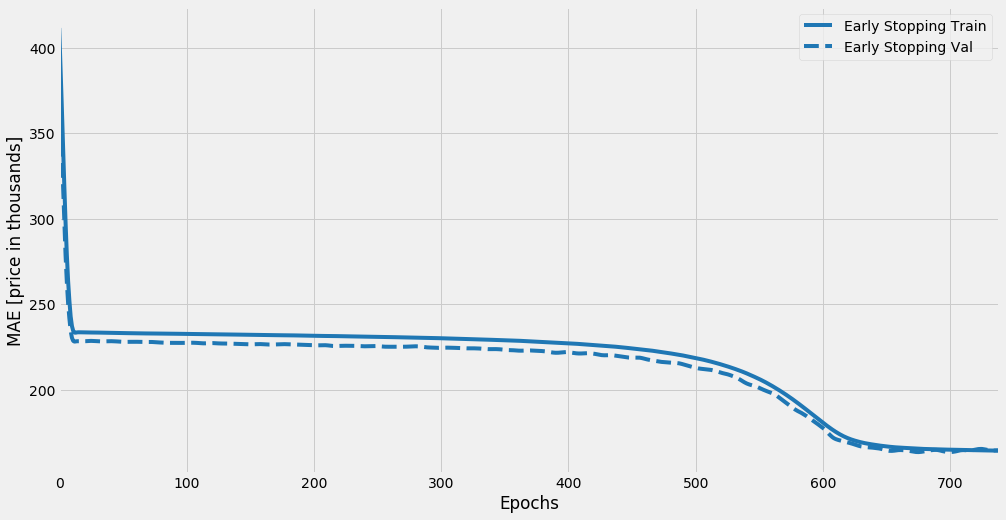

In [844]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylabel('MAE [price in thousands]')

In [846]:
loss, mae, mse = model.evaluate(nn_test_features, nn_test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} price".format(mae))

2162/2162 - 0s - loss: 72431.1542 - mae: 172.4533 - mse: 72431.1484
Testing set Mean Abs Error: 172.45 price


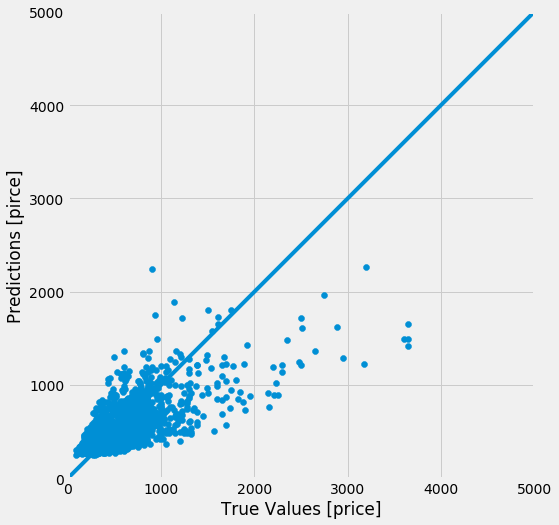

In [847]:
test_predictions = model.predict(nn_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(nn_test_labels, test_predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [pirce]')
lims = [0, 5000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

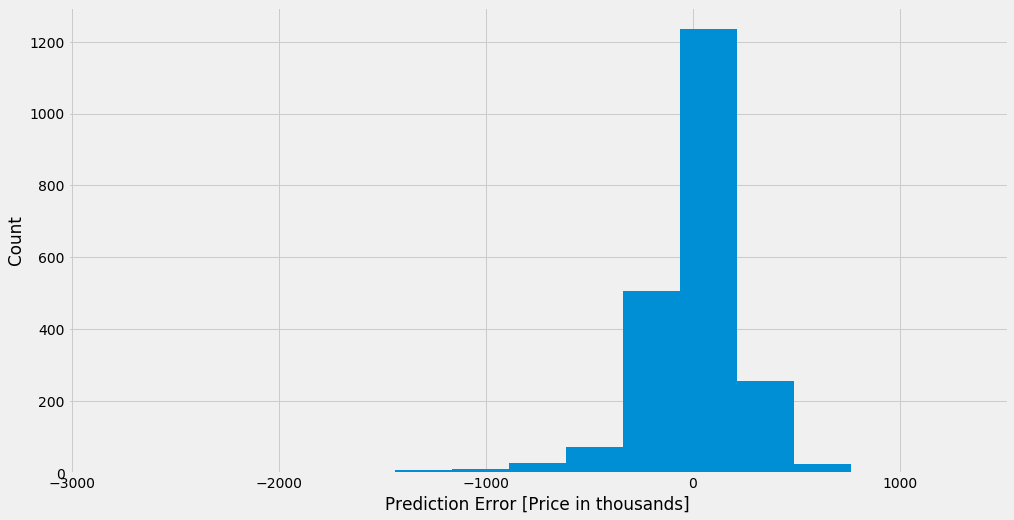

In [805]:
error = test_predictions - nn_test_labels
plt.hist(error, bins = 15)
plt.xlabel("Prediction Error [Price in thousands]")
_ = plt.ylabel("Count")